In [102]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобятся для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [3]:

### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
# g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
#plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [124]:
class IrisNN(BaseEstimator, ClassifierMixin):
    def __init__(self, layers_num = 2, input_num = 4, hidden_num = 5, output_num = 3, rate = 0.05, epoch_num = 3000):
        self.layers_num = layers_num
        self.input_num = input_num
        self.hidden_num = hidden_num
        self.output_num = output_num
        self.rate = rate
        self.epoch_num = epoch_num
        self.accuracy = 0
        
        self.w = [];
        
    def fit(self, X_train, y_train=None):
        
        self.w = []
        self.w.append(2*np.random.random((self.input_num, self.hidden_num)) - 1)
        for i in range(1,self.layers_num-1):
            self.w.append(2*np.random.random((self.hidden_num, self.hidden_num)) - 1)
        self.w.append(2*np.random.random((self.hidden_num, self.output_num)) - 1)

        errors = []
 
        for j in range(self.epoch_num):

            # прямое распространение(feed forward)
            layers = []
            layers.append(X_train)
            for i in range(1, self.layers_num+1):
                layers.append(sigmoid(np.dot(layers[i-1], self.w[i-1])))
                
            # обратное распространение(back propagation) с использованием градиентного спуска
            layer_error = y_train - layers[self.layers_num]
            last_layer_error = layer_error
            layer_delta = layer_error * sigmoid_deriv(layers[self.layers_num])
            self.w[self.layers_num-1] += layers[self.layers_num-1].T.dot(layer_delta) * self.rate
            
            for i in range(1, self.layers_num):
                layer_error = layer_delta.dot(self.w[self.layers_num-i].T)
                layer_delta = layer_error * sigmoid_deriv(layers[self.layers_num-i])
                self.w[self.layers_num-i-1] += layers[self.layers_num-i-1].T.dot(layer_delta) * self.rate
                
            

            error = np.mean(np.abs(last_layer_error))
            errors.append(error)
            accuracy = (1 - error) * 100
            self.accuracy = accuracy
            
        #print("Точность нейронной сети " + str(round(accuracy,2)) + "%")
        
    def predict(self, X_test, y=None):
        # прямое распространение(feed forward)
        layer_t = []
        layer_t.append(X_test)
        for i in range(1, self.layers_num + 1):
            layer_t.append(sigmoid(np.dot(layer_t[i-1], self.w[i-1])))

        layer_error_t = y_test - layer_t[self.layers_num]



        error_t = np.mean(np.abs(layer_error_t))
        accuracy_t = (1 - error_t) * 100
        print("Точность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")
    


In [125]:
iris_nn = IrisNN(10, 4, 5, 3, 0.1, 3000)

In [126]:
iris_nn.fit(X_train, y_train)

Точность нейронной сети 55.72%


In [127]:
iris_nn.predict(X_test)

Точность нейронной сети на тесте 55.23%


In [137]:
data = []
for layers in range(2,11):
    epoch_data = []
    for epoch in range(3000, 15000, 1000):
        iris_nn = IrisNN(layers, 4, 5, 3, 0.1, 3000)
        iris_nn.fit(X_train, y_train)
        epoch_data.append(iris_nn.accuracy)
    
    data.append(epoch_data)

Точность нейронной сети 96.41%
Точность нейронной сети 96.35%
Точность нейронной сети 96.56%
Точность нейронной сети 96.58%
Точность нейронной сети 96.5%
Точность нейронной сети 96.58%
Точность нейронной сети 96.37%
Точность нейронной сети 96.28%
Точность нейронной сети 96.49%
Точность нейронной сети 96.54%
Точность нейронной сети 96.35%
Точность нейронной сети 96.4%
Точность нейронной сети 96.76%
Точность нейронной сети 96.56%
Точность нейронной сети 96.59%
Точность нейронной сети 96.27%
Точность нейронной сети 96.62%
Точность нейронной сети 96.86%
Точность нейронной сети 96.79%
Точность нейронной сети 97.24%
Точность нейронной сети 96.66%
Точность нейронной сети 96.83%
Точность нейронной сети 97.0%
Точность нейронной сети 96.62%
Точность нейронной сети 96.48%
Точность нейронной сети 96.41%
Точность нейронной сети 96.37%
Точность нейронной сети 96.41%
Точность нейронной сети 96.42%
Точность нейронной сети 96.48%
Точность нейронной сети 96.31%
Точность нейронной сети 96.48%
Точность не

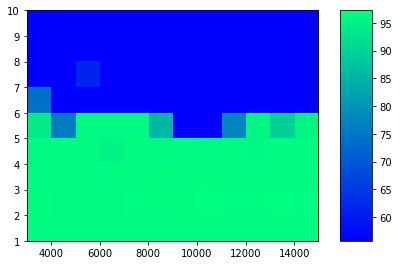

In [162]:
plt.subplot(111)
plt.imshow(data, cmap='winter', aspect='auto', interpolation='none', origin="lower",extent=(3000, 15000, 1, 10))

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [163]:
data = []
for neurons in range(2,11):
    epoch_data = []
    for epoch in range(3000, 15000, 1000):
        iris_nn = IrisNN(2, 4, neurons, 3, 0.1, 3000)
        iris_nn.fit(X_train, y_train)
        epoch_data.append(iris_nn.accuracy)
    
    data.append(epoch_data)

Точность нейронной сети 82.65%
Точность нейронной сети 82.64%
Точность нейронной сети 82.61%
Точность нейронной сети 82.62%
Точность нейронной сети 82.61%
Точность нейронной сети 82.62%
Точность нейронной сети 82.63%
Точность нейронной сети 82.65%
Точность нейронной сети 82.63%
Точность нейронной сети 82.61%
Точность нейронной сети 82.62%
Точность нейронной сети 82.63%
Точность нейронной сети 96.3%
Точность нейронной сети 96.31%
Точность нейронной сети 96.31%
Точность нейронной сети 96.4%
Точность нейронной сети 96.13%
Точность нейронной сети 96.1%
Точность нейронной сети 96.11%
Точность нейронной сети 96.29%
Точность нейронной сети 96.11%
Точность нейронной сети 96.13%
Точность нейронной сети 96.25%
Точность нейронной сети 96.4%
Точность нейронной сети 96.28%
Точность нейронной сети 96.39%
Точность нейронной сети 96.37%
Точность нейронной сети 96.46%
Точность нейронной сети 96.28%
Точность нейронной сети 96.37%
Точность нейронной сети 96.55%
Точность нейронной сети 96.31%
Точность ней

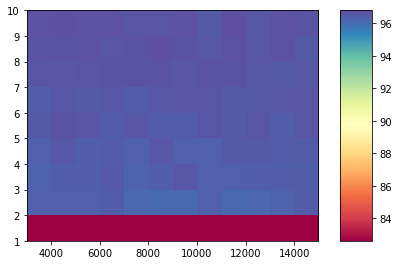

In [167]:
plt.subplot(111)
plt.imshow(data, cmap='Spectral', aspect='auto', interpolation='none', origin="lower",extent=(3000, 15000, 1, 10))

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()